In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import math
import scipy as sp
import copy
import os
import matplotlib.pyplot as plt
from libwallerlab.projects.motiondeblur import blurkernel
import bluranalysis as analysis

# plt.style.use('deblur')

## Blur Len vs Beta

In [2]:
# blur_len = np.arange(1, 100)
# beta = np.arange(0.1,1.0, 0.01)

# image = []
# for _len in blur_len:
#     for _beta in beta:
#         image.append(analysis.getOptimalDnf(_len, _beta))
        
# plt.figure()
# plt.imshow(np.asarray(np.log10(image)).reshape(len(blur_len), len(beta)), vmin=0, vmax=2)

## Show kernel and padded kernel in frequency domain

<IPython.core.display.Javascript object>


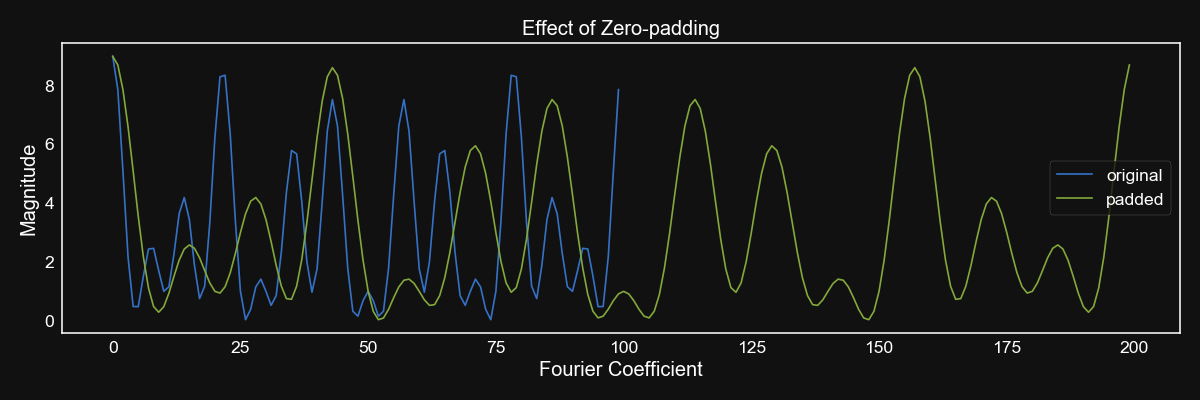

15.930326994915514
15.930326994915514
3.4920657671380355
3.318075690463609


In [3]:
x = np.zeros(100)
x[5] = 1
x[19] =1
x[14] =1
x_padded =np.pad(x, (0,100), mode='constant')

plt.figure()
plt.plot(np.abs(np.fft.fft(x)) ** 2, label='original')
plt.plot(np.abs(np.fft.fft(x_padded)) ** 2, label='padded')
plt.legend()
plt.xlabel('Fourier Coefficient')
plt.ylabel('Magnitude')
plt.title('Effect of Zero-padding')
plt.tight_layout()

print(analysis.calcCondNumFromKernel(x))
print(analysis.calcCondNumFromKernel(x_padded))
print(analysis.calcDnfFromKernel(x))
print(analysis.calcDnfFromKernel(x_padded))

## Pulse Length and DNF

<IPython.core.display.Javascript object>


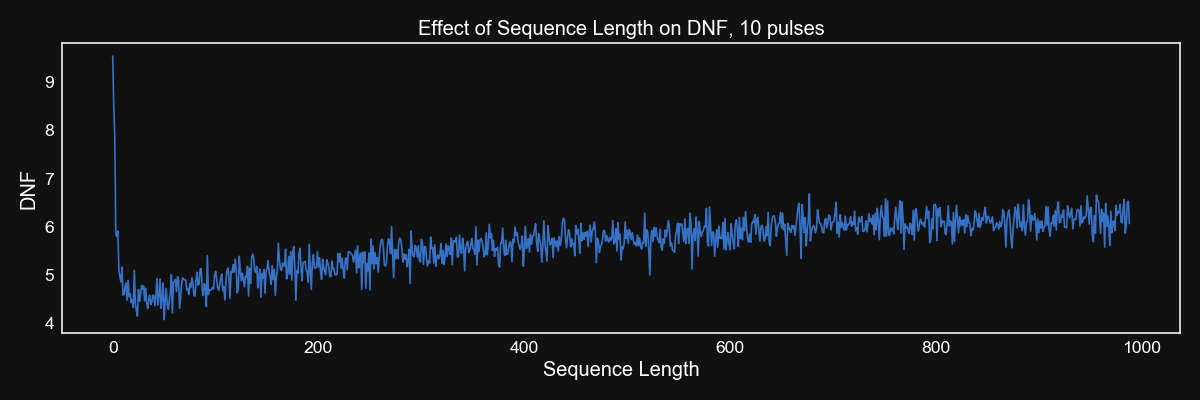

In [4]:
kernel_len_list = np.arange(11,1000)
n_pulses = 10
dnf_list = []
for kernel_len in kernel_len_list:
    dnf_list.append(analysis.getOptimalDnf(kernel_len, n_pulses=n_pulses, n_tests=100))

plt.figure()
plt.plot(dnf_list)
plt.xlabel('Sequence Length')
plt.ylabel('DNF')
plt.title('Effect of Sequence Length on DNF, %d pulses' % n_pulses)
plt.tight_layout()

In [5]:
kernel_len_list = np.arange(51,1000)
n_pulses = 50
dnf_list = []
for kernel_len in kernel_len_list:
    dnf_list.append(analysis.getOptimalDnf(kernel_len, n_pulses=n_pulses, n_tests=100))

plt.figure()
plt.plot(dnf_list)
plt.xlabel('Sequence Length')
plt.ylabel('DNF')
plt.title('Effect of Sequence Length on DNF, %d pulses' % n_pulses)
plt.tight_layout()

KeyboardInterrupt: 

## DNF vs Pulse Count

In [ ]:
pulse_count_list = np.arange(3,1500)
dnf_list = []
for pulse_count in pulse_count_list:
    dnf_list.append(analysis.getOptimalDnf(pulse_count * 2, n_pulses=pulse_count, n_tests=100))

# Perform log fit
coeffs = np.polyfit(np.log10(pulse_count_list), dnf_list, 1)
y = coeffs[0] * np.log10(pulse_count_list) + coeffs[1]

def func_powerlaw(x, m):
    return np.sqrt(2) * x**m - 1

sol1, _ = sp.optimize.curve_fit(func_powerlaw, pulse_count_list, dnf_list, maxfev=2000 )
# sol1 = [0.6116, np.sqrt(2), -1]
yp = func_powerlaw(pulse_count_list, sol1[0])

plt.figure(figsize=(12,5))
plt.plot(pulse_count_list, dnf_list, label='Calculated DNF')
plt.plot(pulse_count_list, yp, label='Power Law Fit')
plt.xlabel('Pulse Count')
plt.ylabel('DNF')
plt.title('Effect of Pulse Count on DNF')
plt.legend()
plt.tight_layout()

## Try with $3\times$ pulse count

<IPython.core.display.Javascript object>


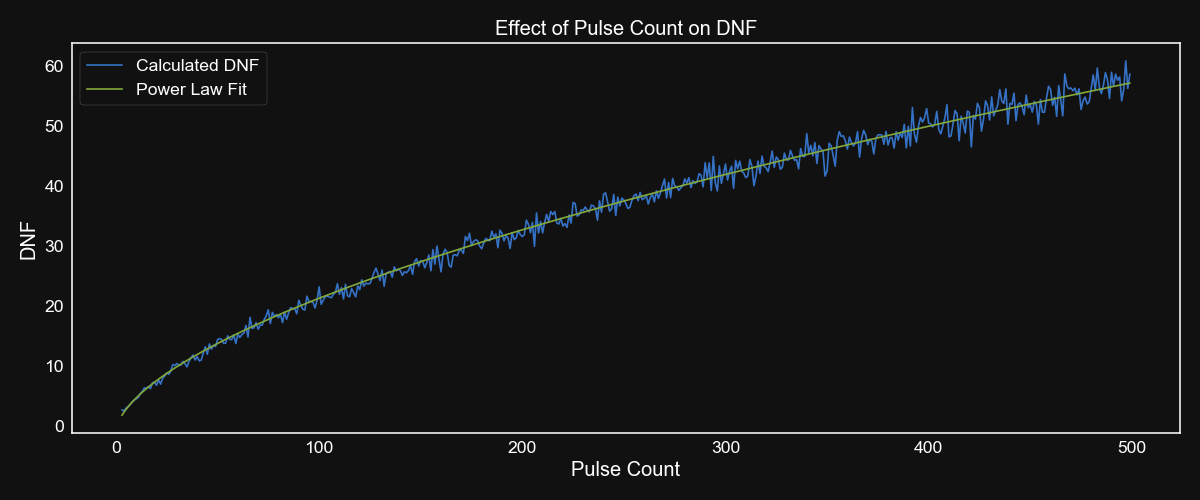

In [8]:
pulse_count_list = np.arange(3,500)
n_pulses = 50
dnf_list = []
for pulse_count in pulse_count_list:
    dnf_list.append(analysis.getOptimalDnf(pulse_count * 3, n_pulses=pulse_count, n_tests=100))

# Perform log fit
coeffs = np.polyfit(np.log10(pulse_count_list), dnf_list, 1)
y = coeffs[0] * np.log10(pulse_count_list) + coeffs[1]

def func_powerlaw(x, m):
    return np.sqrt(2) * x**m - 1

sol1, _ = sp.optimize.curve_fit(func_powerlaw, pulse_count_list, dnf_list, maxfev=2000 )
# sol1 = [0.6116, np.sqrt(2), -1]
yp = func_powerlaw(pulse_count_list, sol1[0])

plt.figure(figsize=(12,5))
plt.plot(pulse_count_list, dnf_list, label='Calculated DNF')
plt.plot(pulse_count_list, yp, label='Power Law Fit')
plt.xlabel('Pulse Count')
plt.ylabel('DNF')
plt.title('Effect of Pulse Count on DNF')
plt.legend()
plt.tight_layout()

## What does the SNR vs n_pulses curve look like?

In [ ]:
N = np.arange(3,500)
c = 10
snr_strobed = np.sqrt(c)
f = func_powerlaw(pulse_count_list, sol1[0])
snr_imaging = np.sqrt(N * c)
snr_dnf = snr_imaging / f

plt.figure()
plt.plot(pulse_count_list, snr_dnf, label='SNR Improvement')
plt.plot(pulse_count_list, snr_strobed * np.ones_like(snr_dnf), label='Baseline (Strobed)')
# plt.plot(pulse_count_list, snr_0, label='Imaging SNR')
plt.legend()
plt.xlabel('Number of Pulses')
plt.ylabel('SNR')
plt.tight_layout()

In [ ]:
# signal_photons = 100
# noise_var = 1000
# G = np.sqrt(1 + noise_var / signal_photons)
# print(G)

# What if you add signal-independent noise?

In [ ]:
N = np.arange(3,500)
c = 1000
var_dependent = N * c
var_independent = 0

# Calculate DNF
f = func_powerlaw(pulse_count_list, sol1[0])

# Calculate SNR for astrobed and coded illum
snr_strobed = c / np.sqrt(c + var_independent)
snr_coded = c * N / (f * np.sqrt(N * c + var_independent))

plt.figure()
plt.plot(pulse_count_list, snr_coded, label='Decoded SNR')
plt.plot(pulse_count_list, snr_strobed * np.ones_like(snr_coded), label='Baseline (Strobed) SNR')
# plt.plot(pulse_count_list, snr_0, label='Imaging SNR')
plt.legend()
plt.xlabel('Number of Pulses')
plt.ylabel('SNR')
plt.xlim((0,300))
plt.tight_layout()

## Plot SNR of Strobed and Coded Illumination Under Different Amounts of  Readout Noise

In [6]:
N = np.arange(3,500)
c = 1000
var_dependent = N * c
var_independent = 500

# Calculate DNF as a function of N
dnf_list = func_powerlaw(pulse_count_list, sol1[0])

# Create variance list
var_independent_list = np.arange(0, 10000, 100)

plt.figure(figsize=(9,7))
snr_strobed_list, snr_coded_list = [], []
for var_independent in var_independent_list:
    for dnf in dnf_list:
        # Calculate SNR for astrobed and coded illum
        snr_strobed = c / np.sqrt(c + var_independent)
        snr_coded = c * N / (f * np.sqrt(N * c + var_independent))
        
        snr_strobed_list.append(snr_strobed)
        snr_coded_list.append(snr_coded)
        
snr_strobed_image = np.asarray(snr_strobed_list).reshape((len(var_independent_list), len(dnf_list)))
snr_coded_image = np.asarray(snr_coded_list).reshape((len(var_independent_list), len(dnf_list)))

NameError: name 'func_powerlaw' is not defined

## Plot SNR of Strobed and Coded Illumination Under Different Amounts of  Readout Noise

In [ ]:
N = pulse_count_list
c = 1000
var_dependent = N * c
var_independent = 500

# Calculate DNF
f = func_powerlaw(pulse_count_list, sol1[0])

plt.figure(figsize=(9,7))

for index, var_independent in enumerate([0, 500, 1000, 5000]):
    
    plt.subplot(411 + index)

    # Calculate SNR for astrobed and coded illum
    snr_strobed = c / np.sqrt(c + var_independent)
    snr_coded = c * N / (f * np.sqrt(N * c + var_independent))

    plt.plot(pulse_count_list, snr_coded, label='Decoded SNR', lw=3)
    plt.plot(pulse_count_list, snr_strobed * np.ones_like(snr_coded), label='Baseline (Strobed) SNR', lw=3)
    # plt.plot(pulse_count_list, snr_0, label='Imaging SNR')
    if index ==0:
        plt.legend()
        
    plt.xlabel('Number of Pulses')
    plt.ylabel('SNR')
    plt.xlim((0,300))
    plt.title('Signal-Independent Noise Variance: %d counts' % var_independent)
    plt.tight_layout()